In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
RS = 7345

# Загрузка данных

In [5]:
DATA_DIR = pathlib.Path("data")

In [6]:
%%time

train, test = [
    pd.read_csv(DATA_DIR.joinpath(filename), index_col="pair_id")
    for filename in (
        "train.csv",
        "test.csv",
    ) 
]

CPU times: user 410 ms, sys: 81.9 ms, total: 492 ms
Wall time: 492 ms


In [7]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [8]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [11]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [12]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
28404,Azienda Generale Italiana Petroli,AGIP ( ENI GROUP),1
480711,Contitech Transportbandsysteme Gmb H,Contitech Usa Inc.,1
97617,Bridgestone Tire Co.,Bridgestone Do Brasil Industria & Comercio Ltda,1
253978,Bridgestone Firestone De Argentina Saic,Bridgestone Tire,1
388901,Yokohama Corp. Of North Ameri,Yokohama Tyre,1
298340,SOPREMA S.A.S.,Soprema sas,1
386384,Exxonmobil Chemical Americas On,Exxonmobil Chemical Co. Baytown Chemical Plant,1
18736,Bridgestone India Automotive,Bridgestone Stargard Sp Zoo,1
164901,Ryohin Keikaku Reliance India Private Ltd.,Reliance Clothing India Private Ltd.,1


In [13]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
263797,"Eia Co., Ltd.",Toyoda Gosei Rubber Mexico S. A. De C. V.,0
424524,P.L.,S.S. Imp. & Exp.,0
190822,Pantos Logistics,Master Shipping Logistica International Ltda Epp,0
492416,Lg Electronics Usa Inc1000 Sylvan,Guangyao Electronics & Plastics (Shenzhen) Co....,0
440466,Sumitomo Industrias Pesadas Do Brasil Ltda,I.B. International,0
275383,Al Tec International,"Agco To Medical Technology (Pinghu) Co., Ltd.",0
44388,Kinder Co. (Pty) ) Ltd.,Starco Internation Co.,0
320376,"Yigang Logistics Co., Ltd.",Sirius Global Logistics,0
96465,Ide Technologies Ltd.,"Nanjing Leitz Metalworking Technology Co., Ltd.",0


# Очистка данных

In [14]:
import pycountry
import re

In [15]:
%%time

for dataset in (train, test):
    for column in ("name_1", 'name_2'):
        dataset[column] = dataset[column].str.lower()

CPU times: user 433 ms, sys: 55.5 ms, total: 489 ms
Wall time: 489 ms


In [16]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [17]:
def multi_str_replace(strings, debug=True):
    re_str = r'\b(?:' + '|'.join(
        [re.escape(s) for s in strings]
    ) + r')(?!\S)'
    if debug:
        print(re_str)
    return re.compile(re_str, re.UNICODE)

In [18]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]
legal_re = multi_str_replace([rf"{entity}" for entity in legal_entities])

t = r'sibur    gmbh inc. gmbh inc pvgmbh  b.v. bova inc.'
t = legal_re.sub('<DEL>', t)
t

\b(?:ltd\.|co\.|inc\.|b\.v\.|s\.c\.r\.l\.|gmbh|pvt\.)(?!\S)


'sibur    <DEL> <DEL> <DEL> inc pvgmbh  <DEL> bova <DEL>'

In [19]:
%%time

for dataset in (train, test):
    dataset.replace(legal_re, "$1 $3", inplace=True)

CPU times: user 2.51 s, sys: 20.3 ms, total: 2.53 s
Wall time: 2.53 s


In [20]:
%%time

for dataset in (train, test):
    dataset.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

CPU times: user 2.14 s, sys: 5.26 ms, total: 2.15 s
Wall time: 2.15 s


In [21]:
import pycountry
countries = [country.name.lower() for country in pycountry.countries]

In [22]:
countries_re = multi_str_replace(countries)

\b(?:aruba|afghanistan|angola|anguilla|\åland\ islands|albania|andorra|united\ arab\ emirates|argentina|armenia|american\ samoa|antarctica|french\ southern\ territories|antigua\ and\ barbuda|australia|austria|azerbaijan|burundi|belgium|benin|bonaire\,\ sint\ eustatius\ and\ saba|burkina\ faso|bangladesh|bulgaria|bahrain|bahamas|bosnia\ and\ herzegovina|saint\ barth\élemy|belarus|belize|bermuda|bolivia\,\ plurinational\ state\ of|brazil|barbados|brunei\ darussalam|bhutan|bouvet\ island|botswana|central\ african\ republic|canada|cocos\ \(keeling\)\ islands|switzerland|chile|china|c\ôte\ d\'ivoire|cameroon|congo\,\ the\ democratic\ republic\ of\ the|congo|cook\ islands|colombia|comoros|cabo\ verde|costa\ rica|cuba|cura\çao|christmas\ island|cayman\ islands|cyprus|czechia|germany|djibouti|dominica|denmark|dominican\ republic|algeria|ecuador|egypt|eritrea|western\ sahara|spain|estonia|ethiopia|finland|fiji|falkland\ islands\ \(malvinas\)|france|faroe\ islands|micronesia\,\ federated\ states

In [23]:
%%time

for dataset in train, test :
    dataset.replace(countries_re, "", inplace=True)

CPU times: user 7.95 s, sys: 33.7 ms, total: 7.98 s
Wall time: 8 s


In [24]:
%%time

for dataset in (train, test):
    dataset.replace(re.compile(r"\s+"), " ", inplace=True)
    dataset.replace(re.compile(r"[^\w\s]"), "", inplace=True)

CPU times: user 5.42 s, sys: 36.9 ms, total: 5.46 s
Wall time: 5.47 s


In [25]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
87840,dongguan oasis plastic products co 1 3,prt 1 3 1 3,0
427392,reliance paul shark fashions pvt 1 3,hr international,0
180334,cook chemical 1 3 1 3,bc,0
439587,francisco mendi sl,ace international ag,0
347451,s r international,htl logistics pvt 1 3,0
446946,seblico sociedad por acciones simplificada,lianda corporation,0
308962,armacell llc conover plant,jama corporation pvt 1 3,0
231007,khalid al dagal trading est,focha trading l l c,0
407038,mason industries,qingdao gw chemical industrial co 1 3,0


In [26]:
test.sample(25)

,name_1,name_2
pair_id,,
158460,ranyal industries 1 3,m industria sa de cv
34198,tk precision plastics 1 3,llc plasteks
9891,johnson controls air conditioning equipment co...,cnr international 1 3
19895,wacker chemical corporation,qingdao jinxian chemicals co 1 3
46041,wa international,fawad traders
9677,bochem sp z oo zakłady chemiczne,rompetrol rafinare sa
192632,a j enterprises,hanif enterprises
150989,tempe sa,teamplay trading enterprieses cc
55404,nalco 1 3,kriska


# Простые метрики сходства строк

In [27]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [28]:
from joblib import Parallel, delayed
import numpy as np


def levenshtein_apply(levenshtein_flavor, rows):
    levenshtein = levenshtein_flavor()
    levenshtein_distance = np.vectorize(levenshtein.distance)
    
    distances = levenshtein_distance(rows[:, 0], rows[:, 1])
    
    return distances


def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


def levenshtein_batch(rows, levenshtein_flavor, n_jobs=8, batch=10000):
    distances = Parallel(n_jobs=n_jobs)(
        delayed(levenshtein_apply)(levenshtein_flavor, chunk) 
        for chunk in tqdm(
            chunker(rows[['name_1', 'name_2']].values, batch),
            total=rows.shape[0] // batch,
        )
    )

    return np.concatenate(distances)

In [29]:
%%time

for dataset in (train, test):
    dataset["levenstein"] = levenshtein_batch(dataset, levenshtein_flavor=Levenshtein)

50it [00:11,  4.42it/s]                        
22it [00:02, 10.85it/s]                        


CPU times: user 871 ms, sys: 251 ms, total: 1.12 s
Wall time: 22.3 s


In [30]:
%%time

for dataset in (train, test):
    dataset["norm_levenstein"] = levenshtein_batch(dataset, levenshtein_flavor=NormalizedLevenshtein)

50it [00:09,  5.15it/s]                        
22it [00:01, 11.18it/s]                        


CPU times: user 735 ms, sys: 172 ms, total: 907 ms
Wall time: 20.6 s


In [31]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries 1 3,enormous industrial trade pvt 1 3,0,18,0.545455
2,apcotex industries 1 3,technocraft industries 1 3,0,9,0.346154
3,rishichem distributors pvt 1 3,dsa,0,28,0.933333
4,powermax rubber factory,1 3 one,0,20,0.869565
5,tress as,longyou industries park zhejiang,0,26,0.812500


In [32]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration 1 3,indl de cuautitlan sa cv,18,0.720000
2,eih 1 3,dongguan wei shi plastic product co 1 3,32,0.820513
3,jsh 1 3,arab shipbuilding and repair yard c,31,0.885714
4,better industrial 1 3,farmacap industria e comercio ltda,22,0.647059
5,equipos inoxidables del norte sa de cv,bel 1 3,33,0.868421


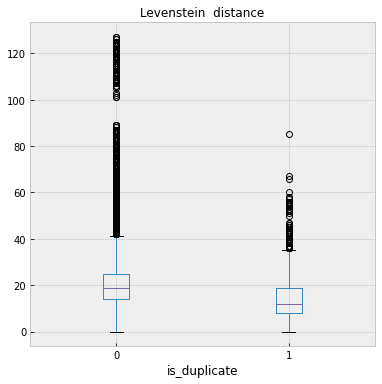

In [33]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

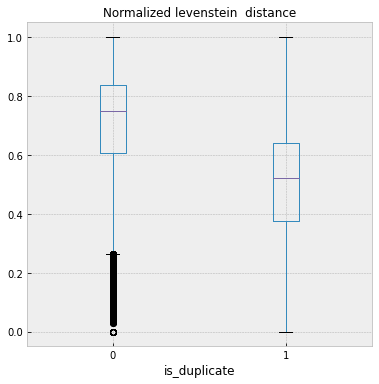

In [34]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Базовая модель

In [35]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [36]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [37]:
%%time

model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

CPU times: user 37.5 s, sys: 1min 26s, total: 2min 3s
Wall time: 2.34 s


In [38]:
%%time

tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

CPU times: user 3.52 s, sys: 8.48 s, total: 12 s
Wall time: 217 ms


In [39]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [40]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    395329
           1       0.13      0.13      0.13      2926

    accuracy                           0.99    398255
   macro avg       0.56      0.56      0.56    398255
weighted avg       0.99      0.99      0.99    398255



In [41]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     98832
           1       0.13      0.14      0.14       732

    accuracy                           0.99     99564
   macro avg       0.56      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [42]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.12904301433811272
0.13700470114170582


# Генерация сабмита

In [43]:
sample_sub = pd.read_csv(DATA_DIR.joinpath("sample_submission.csv"), index_col="pair_id")

In [44]:
sample_sub

,is_duplicate
pair_id,
1,1
2,1
3,1
4,1
5,1
...,...
213245,1
213246,1
213247,1


In [45]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [46]:
sample_sub.is_duplicate.value_counts()

0    211601
1      1648
Name: is_duplicate, dtype: int64

In [47]:
sample_sub.to_csv(
    DATA_DIR.joinpath("baseline_submission.csv.gz"), compression='infer')